In [3]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import akshare as ak
from datetime import datetime, timedelta
from IPython.display import HTML

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  # 也可以设置列宽

In [4]:

# 导入数据
# df = pd.read_csv('data.csv')

def fetch_data(symbol: str, start_date: str = None, end_date: str = None, adjust: str = ""):
    start_date = (datetime.now() - timedelta(days=500)
                  ).strftime('%Y%m%d') if not start_date else start_date
    end_date = datetime.now().strftime('%Y%m%d') if not end_date else end_date
    # 日期    开盘    收盘    最高    最低     成交量           成交额    振幅   涨跌幅   涨跌额   换手率
    try:
        df = ak.stock_zh_a_hist(
            symbol=symbol, start_date=start_date, end_date=end_date, adjust='')
    except Exception as e:
        print(f'ak.stock_zh_a_hist调用出错。{e}')
    return df


symbol = "300031"  
df = fetch_data(symbol=symbol)
df.rename(columns={"日期":"date","开盘":"open","最高":"high","最低":"low","收盘":"close","成交量":"volume"},inplace=True)
df=df[["date","open","high","low","close","volume"]]



In [5]:
import time
def generate_data_chunks(df, period=2):
    index = 0
    while index < len(df):
        yield df.head(index + 1)
        time.sleep(period)
        index += 1

In [6]:
import numpy as np
import pandas as pd
import random
import time

def simulate_tohlcv(frequencies, amplitudes, period=2, initial_price=100.00):
    t = 0  # 时间变量，用于正弦波的计算
    while True:
        price_waves = [amp * np.sin(2 * np.pi * freq * t) for freq, amp in zip(frequencies, amplitudes)]
        open_price = round(initial_price + sum(price_waves), 2)

        high_price = low_price = open_price
        # 模拟周期内的价格变动
        prices = [open_price]
        for _ in range(period - 1):  # 模拟period秒内的价格变动
            change = round(np.random.uniform(-0.01, 0.01) * high_price, 2)
            new_price = max(95.00, min(105.00, prices[-1] + change))
            prices.append(new_price)

        high_price = round(max(prices), 2)
        low_price = round(min(prices), 2)
        close_price = round(prices[-1], 2)

        current_time = pd.Timestamp.now().strftime('%H:%M:%S')
        volume = random.randint(500, 5000)  # 随机生成成交量
        yield {
            'time': current_time,
            'open': open_price,
            'high': high_price,
            'low': low_price,
            'close': close_price,
            'volume': volume
        }
        t += 1 / (60 / period)  # 根据周期调整时间变量的增加量
        time.sleep(period - 0.01)  # 等待直到下一个周期开始，减去0.01秒以补偿计算时间


In [7]:
import pandas as pd
import pandas_ta as ta

class FibonacciCMFTradingStrategy:
    def __init__(self, cmf_threshold=0.05,cmf_window=3, fib_levels=[0.236, 0.382, 0.5, 0.618, 0.786]):
        self.cmf_threshold = cmf_threshold
        self.fib_levels = fib_levels
        self.cmf_window = cmf_window
        self.signals = []

    def update_with_new_data(self, df):
        if len(df) < self.cmf_window: return 
        self.df = df.copy()
        self.high =self.df["high"].max()
        self.low =self.df["low"].max()
        self.calculate_indicators()        
        return self.generate_signals()
    def calculate_fib_levels(self):
        # 计算斐波那契回调水平
        range_diff = self.high - self.low
        fib_levels_dict = {f"fibo_{level}": self.low + range_diff * level for level in self.fib_levels}
        return fib_levels_dict
    def calculate_indicators(self):
        # 计算CMF指标和斐波那契回调水平
        self.df['cmf'] = ta.cmf(
            high=self.df['high'],
            low=self.df['low'],
            close=self.df['close'],
            volume=self.df['volume'],
            length= self.cmf_window
        )
        fib_levels = self.calculate_fib_levels()
        self.df=self.df.assign(**fib_levels)

    def generate_signals(self):
        self.df['signal'] = 0
        for index, row in self.df.iterrows():
            cmf_value = row['cmf']
            # 检查最新的CMF值，并与斐波那契回调水平比较
            for level in self.fib_levels:
                fib_level = row[f"fibo_{level}"]
                if cmf_value >= 0 and cmf_value <= self.cmf_threshold:
                    if row['close'] <= fib_level:
                        self.df.at[index, 'signal'] = 1
                        break
                elif cmf_value < 0 and cmf_value >= -self.cmf_threshold:
                    if row['close'] >= fib_level:
                        self.df.at[index, 'signal'] = -1
                        break
       
        if self.df['signal'].iloc[-1] >0 or self.df['signal'].iloc[-1] < 0:
            columns=["close", "cmf",  "signal"]
            display(HTML(self.df[columns].tail(5).to_html(index=True)))
        return self.df['signal'].iloc[-1]        
        # return signal
    def generate_signals2(self):
        last_row = self.df.iloc[-1]
        cmf_value = last_row['cmf']

        # 检查最新的CMF值，并与斐波那契回调水平比较
        signal = 0
        self.df['signal'] = 0
        for level in self.fib_levels:
            fib_level = self.df[f"fibo_{level}"].iloc[-1]
            # print(level,fib_level)
            if cmf_value > self.cmf_threshold and last_row['close'] < fib_level:
                signal =('buy', f"Fibonacci {level*100:.0f}% level")
                signal =1
                break
            elif cmf_value < -self.cmf_threshold and last_row['close'] > fib_level:
                signal =('sell', f"Fibonacci {level*100:.0f}% level")
                signal =-1
                break
        if self.df['signal'].iloc[-1] >0 or self.df['signal'].iloc[-1] < 0:
            columns=["close", "cmf",  "signal"]
            display(HTML(self.df[columns].tail(5).to_html(index=True)))
        return self.df['signal'].iloc[-1]        




In [8]:
import pandas as pd
import pandas_ta as ta

class FibonacciCMFTradingStrategy:
    def __init__(self, cmf_threshold=0.05,cmf_window=3, fib_levels=[0.236, 0.382, 0.5, 0.618, 0.786]):
        self.cmf_threshold = cmf_threshold
        self.fib_levels = fib_levels
        self.cmf_window = cmf_window
        self.signals = []

    def update_with_new_data(self, df):
        if len(df) < self.cmf_window: return 
        self.df = df.copy()
        self.high =self.df["high"].max()
        self.low =self.df["low"].max()
        self.calculate_indicators()        
        return self.generate_signals()
    def calculate_fib_levels(self):
        # 计算斐波那契回调水平
        range_diff = self.high - self.low
        fib_levels_dict = {f"fibo_{level}": self.low + range_diff * level for level in self.fib_levels}
        return fib_levels_dict
    def calculate_indicators(self):
        # 计算CMF指标和斐波那契回调水平
        self.df['cmf'] = ta.cmf(
            high=self.df['high'],
            low=self.df['low'],
            close=self.df['close'],
            volume=self.df['volume'],
            length= self.cmf_window
        )
        fib_levels = self.calculate_fib_levels()
        self.df=self.df.assign(**fib_levels)

    def generate_signals(self):
        self.df['signal'] = 0
        for index in range(len(self.df)):
            row = self.df.iloc[index]
            cmf_value = row['cmf']

            # 检查CMF值，并与斐波那契回调水平比较
            for level in self.fib_levels:
                fib_level = row[f"fibo_{level}"]
                if (cmf_value > 0 and row['close'] <= fib_level) or \
                   (cmf_value < 0 and row['close'] >= fib_level):
                    self.df.at[index, 'signal'] = 1 if cmf_value > 0 else -1
                    break  # 找到信号后跳出循环
       
        if self.df['signal'].iloc[-1] >0 or self.df['signal'].iloc[-1] < 0:
            columns=["close", "cmf",  "signal"]
            display(HTML(self.df[columns].tail(5).to_html(index=True)))
        return self.df['signal'].iloc[-1]        
    




In [9]:
if __name__ == "__main__":
    generator = generate_data_chunks(df)
    current_chunk = None
    signal_generator = FibonacciCMFTradingStrategy()
    while current_chunk is None or len(current_chunk) < len(df):
        current_chunk = next(generator)
        # print(current_chunk)
        latest_signal = signal_generator.update_with_new_data(current_chunk)
        if latest_signal:
            print("Latest signal:", latest_signal)

,close,cmf,signal
1,19.16,NaN,0
2,19.73,-0.473163,0
3,19.56,-0.475880,0
4,20.09,-0.267607,0
5,21.39,-0.280472,-1


Latest signal: -1


,close,cmf,signal
7,19.96,-0.281844,0
8,19.47,-0.581863,0
9,19.18,-0.271544,0
10,19.24,-0.160996,0
11,19.84,0.292856,1


Latest signal: 1


,close,cmf,signal
9,19.18,-0.271544,0
10,19.24,-0.160996,0
11,19.84,0.292856,1
12,18.85,-0.147042,0
13,19.31,0.003631,1


Latest signal: 1


,close,cmf,signal
10,19.24,-0.160996,0
11,19.84,0.292856,1
12,18.85,-0.147042,0
13,19.31,0.003631,1
14,20.58,0.238704,1


Latest signal: 1


,close,cmf,signal
12,18.85,-0.147042,0
13,19.31,0.003631,1
14,20.58,0.238704,1
15,24.03,0.604926,1
16,24.85,0.327025,1


Latest signal: 1


,close,cmf,signal
14,20.58,0.238704,1
15,24.03,0.604926,1
16,24.85,0.327025,1
17,29.82,0.521088,1
18,29.82,0.424087,1


Latest signal: 1


,close,cmf,signal
15,24.03,0.604926,1
16,24.85,0.327025,1
17,29.82,0.521088,1
18,29.82,0.424087,1
19,26.54,0.240465,1


Latest signal: 1


,close,cmf,signal
16,24.85,0.327025,1
17,29.82,0.521088,1
18,29.82,0.424087,1
19,26.54,0.240465,1
20,28.43,0.138641,1


Latest signal: 1


,close,cmf,signal
18,29.82,0.424087,1
19,26.54,0.240465,1
20,28.43,0.138641,1
21,25.47,-0.268630,0
22,24.59,0.022975,1


Latest signal: 1


,close,cmf,signal
23,24.88,-0.538748,0
24,23.70,-0.459769,0
25,24.22,-0.128673,0
26,24.80,-0.331589,0
27,26.90,0.081787,1


Latest signal: 1


,close,cmf,signal
24,23.70,-0.459769,0
25,24.22,-0.128673,0
26,24.80,-0.331589,0
27,26.90,0.081787,1
28,27.27,0.121813,1


Latest signal: 1


,close,cmf,signal
25,24.22,-0.128673,0
26,24.80,-0.331589,0
27,26.90,0.081787,1
28,27.27,0.121813,1
29,25.70,0.054751,1


Latest signal: 1


,close,cmf,signal
30,24.46,-0.164035,0
31,24.00,-0.670558,0
32,25.20,-0.077831,0
33,24.25,-0.078167,0
34,26.23,0.298151,1


Latest signal: 1


,close,cmf,signal
32,25.20,-0.077831,0
33,24.25,-0.078167,0
34,26.23,0.298151,1
35,26.39,-0.034197,0
36,27.59,0.340766,1


Latest signal: 1


,close,cmf,signal
33,24.25,-0.078167,0
34,26.23,0.298151,1
35,26.39,-0.034197,0
36,27.59,0.340766,1
37,28.22,0.198700,1


Latest signal: 1


,close,cmf,signal
34,26.23,0.298151,1
35,26.39,-0.034197,0
36,27.59,0.340766,1
37,28.22,0.198700,1
38,30.75,0.432677,1


Latest signal: 1


,close,cmf,signal
36,27.59,0.340766,1
37,28.22,0.198700,1
38,30.75,0.432677,1
39,29.85,-0.112502,0
40,30.66,-0.106386,-1


Latest signal: -1


,close,cmf,signal
40,30.66,-0.106386,-1
41,27.88,-0.583778,0
42,28.39,-0.335049,0
43,27.95,-0.366599,0
44,29.91,0.352540,1


Latest signal: 1


,close,cmf,signal
41,27.88,-0.583778,0
42,28.39,-0.335049,0
43,27.95,-0.366599,0
44,29.91,0.352540,1
45,28.50,0.291995,1


Latest signal: 1


,close,cmf,signal
42,28.39,-0.335049,0
43,27.95,-0.366599,0
44,29.91,0.352540,1
45,28.50,0.291995,1
46,28.43,0.094653,1


Latest signal: 1


,close,cmf,signal
43,27.95,-0.366599,0
44,29.91,0.352540,1
45,28.50,0.291995,1
46,28.43,0.094653,1
47,29.60,0.018307,1


Latest signal: 1


,close,cmf,signal
45,28.50,0.291995,1
46,28.43,0.094653,1
47,29.60,0.018307,1
48,28.25,-0.113131,0
49,28.67,0.197092,1


Latest signal: 1


,close,cmf,signal
46,28.43,0.094653,1
47,29.60,0.018307,1
48,28.25,-0.113131,0
49,28.67,0.197092,1
50,29.13,0.202234,1


Latest signal: 1


,close,cmf,signal
47,29.60,0.018307,1
48,28.25,-0.113131,0
49,28.67,0.197092,1
50,29.13,0.202234,1
51,30.33,0.564165,1


Latest signal: 1


,close,cmf,signal
48,28.25,-0.113131,0
49,28.67,0.197092,1
50,29.13,0.202234,1
51,30.33,0.564165,1
52,27.16,0.040375,1


Latest signal: 1


,close,cmf,signal
52,27.16,0.040375,1
53,24.51,-0.343384,0
54,24.70,-0.544193,0
55,24.19,-0.096196,0
56,25.28,0.399960,1


Latest signal: 1


,close,cmf,signal
53,24.51,-0.343384,0
54,24.70,-0.544193,0
55,24.19,-0.096196,0
56,25.28,0.399960,1
57,24.72,0.307150,1


Latest signal: 1


,close,cmf,signal
54,24.70,-0.544193,0
55,24.19,-0.096196,0
56,25.28,0.399960,1
57,24.72,0.307150,1
58,23.78,0.153120,1


Latest signal: 1


,close,cmf,signal
59,23.56,-0.063595,0
60,23.50,-0.159074,0
61,23.51,-0.299288,0
62,23.78,-0.126641,0
63,23.80,0.171530,1


Latest signal: 1


,close,cmf,signal
60,23.50,-0.159074,0
61,23.51,-0.299288,0
62,23.78,-0.126641,0
63,23.80,0.171530,1
64,23.12,0.091172,1


Latest signal: 1


,close,cmf,signal
74,21.92,-0.059332,0
75,21.13,-0.049260,0
76,20.88,-0.349281,0
77,20.89,-0.377634,0
78,20.82,0.185131,1


Latest signal: 1


,close,cmf,signal
75,21.13,-0.049260,0
76,20.88,-0.349281,0
77,20.89,-0.377634,0
78,20.82,0.185131,1
79,20.59,0.230542,1


Latest signal: 1


,close,cmf,signal
76,20.88,-0.349281,0
77,20.89,-0.377634,0
78,20.82,0.185131,1
79,20.59,0.230542,1
80,20.50,0.133050,1


Latest signal: 1


,close,cmf,signal
80,20.50,0.133050,1
81,20.31,-0.343850,0
82,20.73,-0.083995,0
83,21.40,-0.077294,0
84,21.41,0.072993,1


Latest signal: 1


,close,cmf,signal
96,19.91,-0.202903,0
97,19.00,-0.640452,0
98,19.01,-0.729016,0
99,20.36,-0.086492,0
100,20.67,0.335519,1


Latest signal: 1


,close,cmf,signal
97,19.00,-0.640452,0
98,19.01,-0.729016,0
99,20.36,-0.086492,0
100,20.67,0.335519,1
101,20.22,0.386172,1


Latest signal: 1


,close,cmf,signal
100,20.67,0.335519,1
101,20.22,0.386172,1
102,19.77,-0.034771,0
103,19.93,-0.317341,0
104,20.70,0.311430,1


Latest signal: 1


,close,cmf,signal
101,20.22,0.386172,1
102,19.77,-0.034771,0
103,19.93,-0.317341,0
104,20.70,0.311430,1
105,20.98,0.511149,1


Latest signal: 1


,close,cmf,signal
113,16.99,-0.480989,0
114,16.74,-0.435811,0
115,16.55,-0.420229,0
116,16.51,-0.579038,0
117,17.85,0.332332,1


Latest signal: 1


,close,cmf,signal
114,16.74,-0.435811,0
115,16.55,-0.420229,0
116,16.51,-0.579038,0
117,17.85,0.332332,1
118,17.56,0.154244,1


Latest signal: 1


,close,cmf,signal
115,16.55,-0.420229,0
116,16.51,-0.579038,0
117,17.85,0.332332,1
118,17.56,0.154244,1
119,17.78,0.124489,1


Latest signal: 1


,close,cmf,signal
132,15.99,-0.752255,0
133,16.32,-0.505983,0
134,16.42,-0.466565,0
135,16.23,-0.127451,0
136,15.82,0.335484,1


Latest signal: 1


,close,cmf,signal
133,16.32,-0.505983,0
134,16.42,-0.466565,0
135,16.23,-0.127451,0
136,15.82,0.335484,1
137,16.01,0.650589,1


Latest signal: 1


,close,cmf,signal
134,16.42,-0.466565,0
135,16.23,-0.127451,0
136,15.82,0.335484,1
137,16.01,0.650589,1
138,16.10,0.109616,1


Latest signal: 1


,close,cmf,signal
137,16.01,0.650589,1
138,16.10,0.109616,1
139,16.50,-0.050279,0
140,17.90,-0.060084,0
141,17.51,0.308063,1


Latest signal: 1


,close,cmf,signal
138,16.10,0.109616,1
139,16.50,-0.050279,0
140,17.90,-0.060084,0
141,17.51,0.308063,1
142,18.43,0.431045,1


Latest signal: 1


,close,cmf,signal
139,16.50,-0.050279,0
140,17.90,-0.060084,0
141,17.51,0.308063,1
142,18.43,0.431045,1
143,18.27,0.546860,1


Latest signal: 1


,close,cmf,signal
140,17.90,-0.060084,0
141,17.51,0.308063,1
142,18.43,0.431045,1
143,18.27,0.546860,1
144,19.25,0.451030,1


Latest signal: 1


,close,cmf,signal
141,17.51,0.308063,1
142,18.43,0.431045,1
143,18.27,0.546860,1
144,19.25,0.451030,1
145,19.01,0.277109,1


Latest signal: 1


,close,cmf,signal
142,18.43,0.431045,1
143,18.27,0.546860,1
144,19.25,0.451030,1
145,19.01,0.277109,1
146,18.61,0.270405,1


Latest signal: 1


,close,cmf,signal
148,19.27,-0.249828,0
149,18.93,-0.490897,0
150,18.89,-0.380754,0
151,18.80,-0.460705,0
152,19.19,0.245240,1


Latest signal: 1


,close,cmf,signal
149,18.93,-0.490897,0
150,18.89,-0.380754,0
151,18.80,-0.460705,0
152,19.19,0.245240,1
153,19.36,0.325733,1


Latest signal: 1


,close,cmf,signal
150,18.89,-0.380754,0
151,18.80,-0.460705,0
152,19.19,0.245240,1
153,19.36,0.325733,1
154,18.58,0.012221,1


Latest signal: 1


,close,cmf,signal
157,17.66,-0.074279,0
158,18.06,-0.210796,0
159,17.82,-0.145917,0
160,17.55,-0.116854,0
161,19.00,0.352056,1


Latest signal: 1


,close,cmf,signal
158,18.06,-0.210796,0
159,17.82,-0.145917,0
160,17.55,-0.116854,0
161,19.00,0.352056,1
162,19.20,0.457361,1


Latest signal: 1


,close,cmf,signal
159,17.82,-0.145917,0
160,17.55,-0.116854,0
161,19.00,0.352056,1
162,19.20,0.457361,1
163,18.17,0.208576,1


Latest signal: 1


,close,cmf,signal
160,17.55,-0.116854,0
161,19.00,0.352056,1
162,19.20,0.457361,1
163,18.17,0.208576,1
164,19.72,0.182050,1


Latest signal: 1


,close,cmf,signal
163,18.17,0.208576,1
164,19.72,0.182050,1
165,20.25,-0.138302,0
166,20.04,-0.041435,0
167,21.98,0.144652,1


Latest signal: 1


,close,cmf,signal
164,19.72,0.182050,1
165,20.25,-0.138302,0
166,20.04,-0.041435,0
167,21.98,0.144652,1
168,21.76,0.278459,1


Latest signal: 1


,close,cmf,signal
165,20.25,-0.138302,0
166,20.04,-0.041435,0
167,21.98,0.144652,1
168,21.76,0.278459,1
169,21.61,0.172869,1


Latest signal: 1


,close,cmf,signal
169,21.61,0.172869,1
170,21.30,-0.519110,0
171,21.57,-0.345425,0
172,21.39,-0.259989,0
173,22.56,0.320267,1


Latest signal: 1


,close,cmf,signal
177,18.64,-0.268170,0
178,17.48,-0.396289,0
179,17.38,-0.389203,0
180,17.30,-0.239704,0
181,18.54,0.115790,1


Latest signal: 1


,close,cmf,signal
178,17.48,-0.396289,0
179,17.38,-0.389203,0
180,17.30,-0.239704,0
181,18.54,0.115790,1
182,18.22,0.079234,1


Latest signal: 1


,close,cmf,signal
185,16.90,-0.276252,0
186,16.51,-0.341627,0
187,16.63,-0.468522,0
188,16.46,-0.311241,0
189,17.08,0.249654,1


Latest signal: 1


,close,cmf,signal
186,16.51,-0.341627,0
187,16.63,-0.468522,0
188,16.46,-0.311241,0
189,17.08,0.249654,1
190,16.64,0.025987,1


Latest signal: 1


,close,cmf,signal
187,16.63,-0.468522,0
188,16.46,-0.311241,0
189,17.08,0.249654,1
190,16.64,0.025987,1
191,16.66,0.127337,1


Latest signal: 1


,close,cmf,signal
190,16.64,0.025987,1
191,16.66,0.127337,1
192,16.42,-0.164780,0
193,15.91,-0.167982,0
194,16.50,0.274718,1


Latest signal: 1


,close,cmf,signal
194,16.50,0.274718,1
195,16.85,-0.384602,0
196,16.02,-0.469861,0
197,16.85,-0.416957,0
198,16.41,0.015140,1


Latest signal: 1


,close,cmf,signal
195,16.85,-0.384602,0
196,16.02,-0.469861,0
197,16.85,-0.416957,0
198,16.41,0.015140,1
199,16.72,0.532513,1


Latest signal: 1


,close,cmf,signal
196,16.02,-0.469861,0
197,16.85,-0.416957,0
198,16.41,0.015140,1
199,16.72,0.532513,1
200,16.95,0.335118,1


Latest signal: 1


,close,cmf,signal
205,13.60,-0.380301,0
206,11.97,-0.301625,0
207,12.52,-0.090685,0
208,12.40,-0.171931,0
209,13.49,0.302966,1


Latest signal: 1


,close,cmf,signal
206,11.97,-0.301625,0
207,12.52,-0.090685,0
208,12.40,-0.171931,0
209,13.49,0.302966,1
210,14.24,0.460470,1


Latest signal: 1


,close,cmf,signal
207,12.52,-0.090685,0
208,12.40,-0.171931,0
209,13.49,0.302966,1
210,14.24,0.460470,1
211,14.08,0.639309,1


Latest signal: 1


,close,cmf,signal
208,12.40,-0.171931,0
209,13.49,0.302966,1
210,14.24,0.460470,1
211,14.08,0.639309,1
212,14.18,0.335246,1


Latest signal: 1


,close,cmf,signal
209,13.49,0.302966,1
210,14.24,0.460470,1
211,14.08,0.639309,1
212,14.18,0.335246,1
213,14.56,0.191981,1


Latest signal: 1


,close,cmf,signal
210,14.24,0.460470,1
211,14.08,0.639309,1
212,14.18,0.335246,1
213,14.56,0.191981,1
214,15.09,0.455314,1


Latest signal: 1


,close,cmf,signal
211,14.08,0.639309,1
212,14.18,0.335246,1
213,14.56,0.191981,1
214,15.09,0.455314,1
215,15.50,0.612964,1


Latest signal: 1


,close,cmf,signal
212,14.18,0.335246,1
213,14.56,0.191981,1
214,15.09,0.455314,1
215,15.50,0.612964,1
216,16.24,0.712148,1


Latest signal: 1


,close,cmf,signal
214,15.09,0.455314,1
215,15.50,0.612964,1
216,16.24,0.712148,1
217,15.30,-0.064882,0
218,15.96,0.068713,1


Latest signal: 1


,close,cmf,signal
216,16.24,0.712148,1
217,15.30,-0.064882,0
218,15.96,0.068713,1
219,15.90,-0.203585,0
220,15.82,0.499308,1


Latest signal: 1


,close,cmf,signal
217,15.30,-0.064882,0
218,15.96,0.068713,1
219,15.90,-0.203585,0
220,15.82,0.499308,1
221,15.42,0.026017,1


Latest signal: 1


,close,cmf,signal
218,15.96,0.068713,1
219,15.90,-0.203585,0
220,15.82,0.499308,1
221,15.42,0.026017,1
222,15.41,0.072705,1


Latest signal: 1


,close,cmf,signal
221,15.42,0.026017,1
222,15.41,0.072705,1
223,14.83,-0.503971,0
224,15.01,-0.045357,0
225,15.38,0.174703,1


Latest signal: 1


,close,cmf,signal
222,15.41,0.072705,1
223,14.83,-0.503971,0
224,15.01,-0.045357,0
225,15.38,0.174703,1
226,15.51,0.470308,1


Latest signal: 1


,close,cmf,signal
223,14.83,-0.503971,0
224,15.01,-0.045357,0
225,15.38,0.174703,1
226,15.51,0.470308,1
227,16.25,0.387864,1


Latest signal: 1


,close,cmf,signal
224,15.01,-0.045357,0
225,15.38,0.174703,1
226,15.51,0.470308,1
227,16.25,0.387864,1
228,15.76,0.143764,1


Latest signal: 1


,close,cmf,signal
225,15.38,0.174703,1
226,15.51,0.470308,1
227,16.25,0.387864,1
228,15.76,0.143764,1
229,15.81,0.316128,1


Latest signal: 1


,close,cmf,signal
226,15.51,0.470308,1
227,16.25,0.387864,1
228,15.76,0.143764,1
229,15.81,0.316128,1
230,16.20,0.322685,1


Latest signal: 1


,close,cmf,signal
227,16.25,0.387864,1
228,15.76,0.143764,1
229,15.81,0.316128,1
230,16.20,0.322685,1
231,16.11,0.171001,1


Latest signal: 1


,close,cmf,signal
228,15.76,0.143764,1
229,15.81,0.316128,1
230,16.20,0.322685,1
231,16.11,0.171001,1
232,16.40,0.191643,1


Latest signal: 1


,close,cmf,signal
236,14.78,-0.333778,0
237,13.81,-0.755748,0
238,14.44,-0.250055,0
239,14.28,-0.032286,0
240,14.94,0.656901,1


Latest signal: 1


,close,cmf,signal
237,13.81,-0.755748,0
238,14.44,-0.250055,0
239,14.28,-0.032286,0
240,14.94,0.656901,1
241,14.49,0.287874,1


Latest signal: 1


,close,cmf,signal
248,12.35,-0.488370,0
249,11.58,-0.767369,0
250,12.26,-0.261836,0
251,12.34,-0.069436,0
252,12.03,0.144447,1


Latest signal: 1


,close,cmf,signal
249,11.58,-0.767369,0
250,12.26,-0.261836,0
251,12.34,-0.069436,0
252,12.03,0.144447,1
253,12.08,0.015938,1


Latest signal: 1


,close,cmf,signal
251,12.34,-0.069436,0
252,12.03,0.144447,1
253,12.08,0.015938,1
254,12.28,-0.000019,0
255,12.63,0.544205,1


Latest signal: 1


,close,cmf,signal
252,12.03,0.144447,1
253,12.08,0.015938,1
254,12.28,-0.000019,0
255,12.63,0.544205,1
256,12.59,0.420355,1


Latest signal: 1


,close,cmf,signal
253,12.08,0.015938,1
254,12.28,-0.000019,0
255,12.63,0.544205,1
256,12.59,0.420355,1
257,12.92,0.656084,1


Latest signal: 1


,close,cmf,signal
254,12.28,-0.000019,0
255,12.63,0.544205,1
256,12.59,0.420355,1
257,12.92,0.656084,1
258,14.18,0.583193,1


Latest signal: 1


,close,cmf,signal
255,12.63,0.544205,1
256,12.59,0.420355,1
257,12.92,0.656084,1
258,14.18,0.583193,1
259,14.36,0.418225,1


Latest signal: 1


,close,cmf,signal
256,12.59,0.420355,1
257,12.92,0.656084,1
258,14.18,0.583193,1
259,14.36,0.418225,1
260,14.54,0.187083,1


Latest signal: 1


,close,cmf,signal
262,14.05,-0.400125,0
263,14.34,-0.214126,0
264,14.16,-0.255375,0
265,13.83,-0.071951,0
266,15.06,0.298151,1


Latest signal: 1


,close,cmf,signal
267,14.60,-0.068285,0
268,14.37,-0.096451,0
269,14.37,-0.476581,0
270,14.32,-0.022112,0
271,14.92,0.635092,1


Latest signal: 1


,close,cmf,signal
268,14.37,-0.096451,0
269,14.37,-0.476581,0
270,14.32,-0.022112,0
271,14.92,0.635092,1
272,14.86,0.792681,1


Latest signal: 1


,close,cmf,signal
269,14.37,-0.476581,0
270,14.32,-0.022112,0
271,14.92,0.635092,1
272,14.86,0.792681,1
273,14.47,0.436072,1


Latest signal: 1


,close,cmf,signal
275,14.38,-0.359038,0
276,13.96,-0.182228,0
277,13.99,-0.028643,0
278,14.00,-0.163654,0
279,14.46,0.179067,1


Latest signal: 1


,close,cmf,signal
276,13.96,-0.182228,0
277,13.99,-0.028643,0
278,14.00,-0.163654,0
279,14.46,0.179067,1
280,14.29,0.197183,1


Latest signal: 1


,close,cmf,signal
277,13.99,-0.028643,0
278,14.00,-0.163654,0
279,14.46,0.179067,1
280,14.29,0.197183,1
281,14.18,0.144605,1


Latest signal: 1


,close,cmf,signal
282,13.96,-0.169019,0
283,13.38,-0.440494,0
284,13.55,-0.636205,0
285,13.95,-0.091851,0
286,14.28,0.541128,1


Latest signal: 1


,close,cmf,signal
283,13.38,-0.440494,0
284,13.55,-0.636205,0
285,13.95,-0.091851,0
286,14.28,0.541128,1
287,14.39,0.580037,1


Latest signal: 1


,close,cmf,signal
284,13.55,-0.636205,0
285,13.95,-0.091851,0
286,14.28,0.541128,1
287,14.39,0.580037,1
288,14.64,0.493013,1


Latest signal: 1


,close,cmf,signal
285,13.95,-0.091851,0
286,14.28,0.541128,1
287,14.39,0.580037,1
288,14.64,0.493013,1
289,14.66,0.024586,1


Latest signal: 1


,close,cmf,signal
286,14.28,0.541128,1
287,14.39,0.580037,1
288,14.64,0.493013,1
289,14.66,0.024586,1
290,15.01,0.285632,1


Latest signal: 1


,close,cmf,signal
287,14.39,0.580037,1
288,14.64,0.493013,1
289,14.66,0.024586,1
290,15.01,0.285632,1
291,14.77,0.021372,1


Latest signal: 1


,close,cmf,signal
292,14.36,-0.016040,0
293,14.36,-0.538918,0
294,13.95,-0.676733,0
295,13.48,-0.594725,0
296,14.46,0.021174,1


Latest signal: 1


,close,cmf,signal
294,13.95,-0.676733,0
295,13.48,-0.594725,0
296,14.46,0.021174,1
297,14.15,-0.024278,0
298,14.37,0.187482,1


Latest signal: 1


,close,cmf,signal
296,14.46,0.021174,1
297,14.15,-0.024278,0
298,14.37,0.187482,1
299,14.50,-0.018938,0
300,14.66,0.278244,1


Latest signal: 1


,close,cmf,signal
297,14.15,-0.024278,0
298,14.37,0.187482,1
299,14.50,-0.018938,0
300,14.66,0.278244,1
301,14.48,0.272060,1


Latest signal: 1


,close,cmf,signal
301,14.48,0.272060,1
302,14.04,-0.238729,0
303,14.27,-0.120634,0
304,14.59,-0.463905,0
305,15.45,0.347462,1


Latest signal: 1


,close,cmf,signal
302,14.04,-0.238729,0
303,14.27,-0.120634,0
304,14.59,-0.463905,0
305,15.45,0.347462,1
306,15.52,0.086844,1


Latest signal: 1


,close,cmf,signal
303,14.27,-0.120634,0
304,14.59,-0.463905,0
305,15.45,0.347462,1
306,15.52,0.086844,1
307,15.69,0.306824,1


Latest signal: 1


,close,cmf,signal
304,14.59,-0.463905,0
305,15.45,0.347462,1
306,15.52,0.086844,1
307,15.69,0.306824,1
308,16.05,0.249958,1


Latest signal: 1


,close,cmf,signal
305,15.45,0.347462,1
306,15.52,0.086844,1
307,15.69,0.306824,1
308,16.05,0.249958,1
309,15.39,0.176360,1


Latest signal: 1


,close,cmf,signal
306,15.52,0.086844,1
307,15.69,0.306824,1
308,16.05,0.249958,1
309,15.39,0.176360,1
310,15.51,0.325530,1


Latest signal: 1


,close,cmf,signal
307,15.69,0.306824,1
308,16.05,0.249958,1
309,15.39,0.176360,1
310,15.51,0.325530,1
311,15.84,0.064773,1


Latest signal: 1


,close,cmf,signal
308,16.05,0.249958,1
309,15.39,0.176360,1
310,15.51,0.325530,1
311,15.84,0.064773,1
312,15.39,0.414025,1


Latest signal: 1


,close,cmf,signal
309,15.39,0.176360,1
310,15.51,0.325530,1
311,15.84,0.064773,1
312,15.39,0.414025,1
313,15.60,0.226494,1


Latest signal: 1


,close,cmf,signal
310,15.51,0.325530,1
311,15.84,0.064773,1
312,15.39,0.414025,1
313,15.60,0.226494,1
314,15.71,0.210539,1


Latest signal: 1


,close,cmf,signal
315,15.21,-0.150117,0
316,14.96,-0.463394,0
317,15.24,-0.490387,0
318,15.34,-0.094466,0
319,15.69,0.536351,1


Latest signal: 1


,close,cmf,signal
316,14.96,-0.463394,0
317,15.24,-0.490387,0
318,15.34,-0.094466,0
319,15.69,0.536351,1
320,15.62,0.191251,1


Latest signal: 1


,close,cmf,signal
317,15.24,-0.490387,0
318,15.34,-0.094466,0
319,15.69,0.536351,1
320,15.62,0.191251,1
321,16.20,0.427901,1


Latest signal: 1


,close,cmf,signal
327,14.96,-0.141209,0
328,14.62,-0.431878,0
329,14.39,-0.608949,0
330,14.30,-0.335910,0
331,14.44,0.171789,1


Latest signal: 1


,close,cmf,signal
328,14.62,-0.431878,0
329,14.39,-0.608949,0
330,14.30,-0.335910,0
331,14.44,0.171789,1
332,15.25,0.204751,1


Latest signal: 1


/tmp/ipykernel_3753113/2043196408.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Signal'][10:] = np.where(df['SMA_10'][10:] > df['SMA_50'][10:], 1, 0)
/tmp/ipykernel_3753113/2043196408.py:24: SettingWithCopyWarning: 
A value is try

ValueError: x and y must be the same size

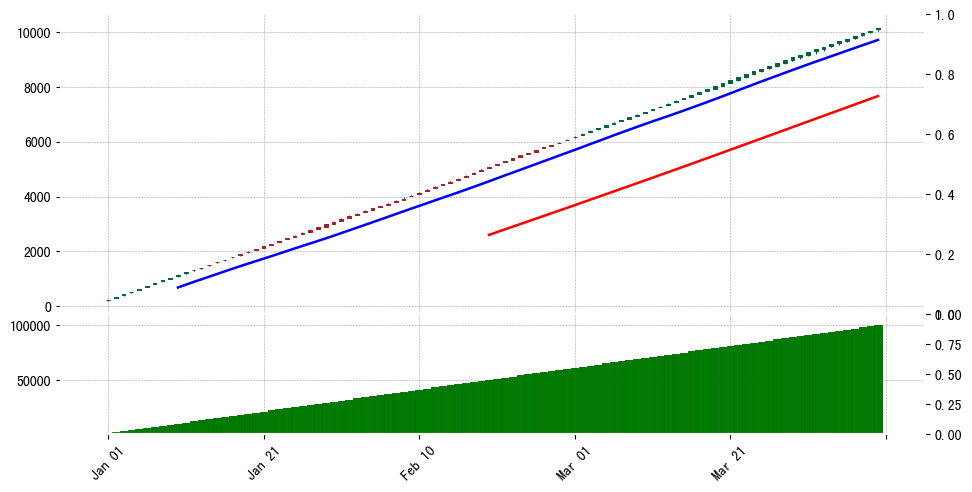

In [4]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 创建示例数据
data = {
    'Date': pd.date_range(start='2024-01-01', periods=100, freq='D'),
    'Open': np.random.normal(loc=100, scale=10, size=100).cumsum() + 100,
    'High': np.random.normal(loc=100, scale=10, size=100).cumsum() + 100,
    'Low': np.random.normal(loc=100, scale=10, size=100).cumsum() + 100,
    'Close': np.random.normal(loc=100, scale=10, size=100).cumsum() + 100,
    'Volume': np.random.normal(loc=1000, scale=10, size=100).cumsum() + 100
}
df = pd.DataFrame(data)
df.set_index('Date', inplace=True)

# 计算移动平均线
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# 定义买卖信号
df['Signal'] = 0
df['Signal'][10:] = np.where(df['SMA_10'][10:] > df['SMA_50'][10:], 1, 0)
df['Position'] = df['Signal'].diff()

# 买入信号
buy_signals = df[df['Position'] == 1]
# 卖出信号
sell_signals = df[df['Position'] == -1]

# 绘制蜡烛图
apds = [mpf.make_addplot(df['SMA_10'], color='blue', linestyle='-', label='10-Day SMA'),
        mpf.make_addplot(df['SMA_50'], color='red', linestyle='-', label='50-Day SMA'),
        mpf.make_addplot(buy_signals['Close'], type='scatter', markersize=200, marker='^', color='green', label='Buy Signal'),
        mpf.make_addplot(sell_signals['Close'], type='scatter', markersize=200, marker='v', color='red', label='Sell Signal')]

mpf.plot(df, type='candle', style='charles', addplot=apds, volume=True, figsize=(12, 6), title='Candlestick Chart with Buy/Sell Signals')

# 显示图表
plt.show()

In [1]:
for i in range(7):
  print(f'Iteration {i+1}:')


Iteration 1:
Iteration 2:
Iteration 3:
Iteration 4:
Iteration 5:
Iteration 6:
Iteration 7:


In [13]:
import akshare as ak

fund_etf_spot_em_df = ak.fund_etf_spot_em()
fund_etf_spot_em_df=fund_etf_spot_em_df[fund_etf_spot_em_df['代码'].astype(str).str.startswith('159')]
print(fund_etf_spot_em_df[:50])

        代码            名称    最新价  IOPV实时估值  基金折价率    涨跌额   涨跌幅         成交量  \
0   159566       储能电池ETF  1.058    1.0563  -0.16  0.044  4.34     58797.0   
2   159863       光伏ETF基金  0.436    0.4352  -0.18  0.017  4.06    217485.0   
6   159609       光伏龙头ETF  0.383    0.3809  -0.55  0.014  3.79    506732.0   
7   159864       光伏50ETF  0.417    0.4174   0.10  0.015  3.73    750799.0   
9   159857         光伏ETF  0.552    0.5524   0.07  0.019  3.56   1618181.0   
10  159618     光伏ETF指数基金  0.525    0.5256   0.11  0.018  3.55    215852.0   
13  159306       汽车零件ETF  0.827    0.8267  -0.04  0.027  3.38     31441.0   
15  159565      汽车零部件ETF  0.890    0.8902   0.02  0.028  3.25     13573.0   
17  159667       工业母机ETF  0.743    0.7426  -0.05  0.022  3.05    403610.0   
18  159663         机床ETF  0.747    0.7471   0.01  0.022  3.03    122795.0   
19  159796       电池50ETF  0.460    0.4602   0.04  0.013  2.91    242656.0   
21  159804      创中盘88ETF  0.836    0.8323  -0.44  0.023  2.83       857.0   